In [1]:

!pip install numpy torch sympy mod blobfile pandas seaborn matplotlib tqdm einops wand

import sys
import os

sys.path.append(os.path.abspath(os.path.join(os.getcwd(), os.pardir)))

from contextlib import suppress
from dataclasses import dataclass, asdict
from datetime import datetime
from typing import Callable, Literal, Optional, Union, Tuple, List
from copy import deepcopy

import numpy as np
import pandas as pd
import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torch import optim
import wandb
from tqdm.notebook import tqdm
import ipywidgets as widgets
import wandb

import matplotlib as mpl
from matplotlib.colors import LogNorm
import seaborn as sns
import matplotlib.pyplot as plt

from patterns.dataset import ModularArithmetic, Operator
from patterns.transformer import Transformer
from patterns.utils import generate_run_name
from patterns.learner import Config, GrokkingLearner, GrokkingConfig

from unifying.sweep import get_history, handle_outliers, extract_run, extract_slice, get_pivot
from unifying.plotting import plot, plot_interpolation_overview, plot_slice, BLUE, RED, BLUES, REDS, plot_all_details, plot_details, create_heatmap
from matplotlib import cm, colors, gridspec


DEFAULT_MODULUS = 113
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

sns.set_theme(style="darkgrid")

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.6/143.6 KB 6.0 MB/s eta 0:00:00


# Unifying Grokking & DD

In [2]:
config = GrokkingConfig(
    lr=1e-3,
    d_model=32,
    weight_decay=.3,
    test_acc_criterion=1.,
    device=DEVICE,  
    modulus=1000
)

# ModularArithmetic.generate(
#     modulus=2000,
#     operator="+",
# )
GrokkingLearner.create(config, train_dataloader, val_dataloader)

NameError: name 'train_dataloader' is not defined

In [5]:
# Dataset

train_dataset, val_dataset = ModularArithmetic.generate_split(
    operator=config.operator,
    modulus=config.modulus,
    frac_label_noise=config.frac_label_noise,
    seed=config.seed,
    shuffle=config.shuffle,
    frac_train=config.frac_train,
)

# Dataloaders

train_dataloader = DataLoader(train_dataset, batch_size=config.batch_size)
val_dataloader = DataLoader(val_dataset, batch_size=config.batch_size)

In [4]:
# Logging
date_time = datetime.now().strftime("%Y%m%d-%H%M%S-%f")
mode = "disabled" if config.no_logging else None

In [5]:
# Training

def train_test_run():
    learner = GrokkingLearner.create(config, train_dataloader, val_dataloader)

    if config.resume_run_id is None:
        wandb.init(
            project=config.wandb_project,
            id=date_time,
            settings=wandb.Settings(start_method="thread"),
            name=learner.name,
            config=asdict(config),
            mode=mode,
        )
    else:
        wandb.init(
            project=config.wandb_project,
            id=config.resume_run_id,
            resume="must",
            settings=wandb.Settings(start_method="thread"),
            name=learner.name,
            config=asdict(config),
            mode=mode,
        )
    wandb.watch(learner.model)
    
    try: 
        learner.train()
    except KeyboardInterrupt:
        wandb.finish()


train_test_run()

Model has 226816 trainable parameters


Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: jqhoogland. Use `wandb login --relogin` to force relogin


  0%|          | 0/100000 [00:00<?, ?it/s]

Test accuracy criterion reached


# Sweeps

To initialize a sweep, run the following command:

```shell
wandb sweep --project grokking <config.yml>
```

where `<config.yml>` is the config file you want to use.

To run the sweep, run the following command:

```shell
wandb agent <sweep_id> --function train
```

where `<sweep_id>` is the id of the sweep you want to run. You can find the sweep id by running `wandb sweep ls`.

You can pass an optional `--count` flag to the `wandb agent` command to specify the number of runs you want to execute. If you don't pass this flag, the agent will run until all the runs in the sweep are complete (for a grid sweep).

On a multi-GPU machine, you can run multiple agents in parallel through the following:

```shell
CUDA_VISIBLE_DEVICES=0 wandb agent <sweep_id> &
CUDA_VISIBLE_DEVICES=1 wandb agent <sweep_id> &
...
```

In [3]:
import json
import numpy as np

def generate_coarse_to_fine_grid_sweep(min_, max_, total_steps, step_sizes=[10, 5, 3, 1], type_="log"):
    if type_ == "log":
        # Generate the logscale range
        grid = np.logspace(np.log10(min_), np.log10(max_), total_steps)
    elif type_ == "linear":
        grid = np.linspace(min_, max_, total_steps)
    else:
        grid = np.arange(min_, max_, int((max_ - min_) / total_steps))

    # Initialize an empty list to store the rearranged elements
    rearranged_grid = []

    # Iterate over the step sizes and merge the sublists
    for step in step_sizes:
        for i in range(0, len(grid), step):
            if grid[i] not in rearranged_grid:
                rearranged_grid.append(grid[i])

    return rearranged_grid


def rearrange_coarse_to_fine(grid: List, step_sizes=[10, 5, 3, 1]):
    # Initialize an empty list to store the rearranged elements
    rearranged_grid = []

    # Iterate over the step sizes and merge the sublists
    for step in step_sizes:
        for i in range(0, len(grid), step):
            if grid[i] not in rearranged_grid:
                rearranged_grid.append(grid[i])

    return rearranged_grid

## Model-wise

In [15]:
model_grid_1 = generate_coarse_to_fine_grid_sweep(1, 300, 31, step_sizes=[10, 5, 3, 1], type_="log")

# Drop duplicates and convert to int but maintain order
model_grid_1 = list(dict.fromkeys((int(i) for i in model_grid_1)))

model_grid_2 = generate_coarse_to_fine_grid_sweep(0, 300, 100, step_sizes=[10, 5, 3, 1], type_="range")
model_grid_2 = list(dict.fromkeys((int(i) for i in model_grid_2 if int(i) not in model_grid_1 and i)))
print(len(model_grid_2), json.dumps(model_grid_2))

94 [60, 90, 120, 150, 180, 210, 240, 270, 15, 45, 75, 105, 135, 165, 195, 225, 255, 285, 18, 27, 36, 63, 72, 81, 99, 108, 117, 126, 144, 153, 162, 171, 189, 198, 207, 216, 234, 243, 252, 261, 279, 288, 297, 12, 21, 24, 33, 39, 42, 48, 51, 57, 66, 69, 78, 84, 87, 93, 96, 102, 111, 114, 123, 129, 132, 138, 141, 147, 156, 159, 168, 174, 177, 183, 186, 192, 201, 204, 213, 219, 222, 228, 231, 237, 246, 249, 258, 264, 267, 273, 276, 282, 291, 294]


## Sample-wise

In [ ]:
# Frac train 

frac_train_grid = generate_coarse_to_fine_grid_sweep(0, 1.05, 20, step_sizes=[.5, .2, .1, .05], type_="range")
print(frac_train_grid)

In [5]:
# Frac train 
mnist_frac_train_grid = generate_coarse_to_fine_grid_sweep(0.01, .10, 25, step_sizes=[10, 5, 3, 1], type_="log")
print(mnist_frac_train_grid)

[0.01, 0.026101572156825358, 0.06812920690579612, 0.016155980984398736, 0.042169650342858224, 0.01333521432163324, 0.01778279410038923, 0.023713737056616554, 0.03162277660168379, 0.05623413251903491, 0.07498942093324558, 0.1, 0.011006941712522098, 0.012115276586285882, 0.014677992676220698, 0.019573417814876596, 0.021544346900318832, 0.02872984833353664, 0.03480700588428409, 0.03831186849557287, 0.046415888336127774, 0.05108969774506927, 0.061896581889126036, 0.08254041852680181, 0.09085175756516867]


In [5]:
# Modulus

import warnings


def sieve_of_eratosthenes(n):
    """
    Generate all prime numbers between 2 and n using the Sieve of Eratosthenes algorithm.
    """
    # Create a boolean array "prime[0..n]" and initialize
    # all entries it as true. A value in prime[i] will
    # finally be false if i is Not a prime, else true.
    prime = [True for i in range(n+1)]
    p = 2
    while p**2 <= n:
        # If prime[p] is not changed, then it is a prime
        if prime[p]:
            # Update all multiples of p
            for i in range(p**2, n+1, p):
                prime[i] = False
        p += 1

    # Generate list of primes
    primes = [p for p in range(2, n+1) if prime[p]]
    return primes


def primes_range(min_, max_, num_primes):
    """
    Generate a list of primes between min_ and max_, 
    following a near-logarithmic scale with num_primes elements.
    """
    all_primes = [p for p in sieve_of_eratosthenes(max_) if p >= min_]

    # Generate the logscale range
    grid = np.logspace(np.log10(min_), np.log10(max_), num_primes)

    # Find the closest prime to each element in the grid
    primes = []
    used_indices = set()

    for i in range(len(grid)):
        # Find the index of the closest prime to the grid element
        idx = np.argmin(np.abs(np.array(all_primes) - grid[i]))
        
        while idx in used_indices:
            idx += 1

        if idx >= len(all_primes):
            warnings.warn(f"Ran out of primes to choose from. Returning {len(primes)} primes.")
            break

        used_indices.add(idx)
        primes.append(all_primes[idx])

    return primes

modulus_grid = rearrange_coarse_to_fine(primes_range(1, 1000, 31), [10, 5, 3, 1])
print(modulus_grid)

[31, 97, 311, 997, 53, 173, 557, 43, 61, 83, 127, 241, 349, 499, 701, 37, 41, 47, 67, 79, 109, 137, 157, 193, 223, 277, 389, 443, 631, 787, 887]


## Regularization-wise

In [6]:
wds = generate_coarse_to_fine_grid_sweep(0.05, 10, 51)
print(json.dumps(wds))

[0.049999999999999996, 0.14426999059072135, 0.41627660370093655, 1.201124433981431, 3.4657242157757318, 10.0, 0.08493232323171235, 0.24506370946974493, 0.7071067811865475, 2.0402857733683692, 5.887040186524747, 0.06871187569715699, 0.09442643723643111, 0.12976435235830103, 0.17832704098331334, 0.3367757428593863, 0.46280985962343724, 0.6360106709172864, 0.87402972324268, 1.6506302560910038, 2.2683580195698294, 3.1172626855466286, 4.283859323293314, 8.090191470413135, 0.05558922306812267, 0.06180323442635004, 0.07639279571116754, 0.10498184566128109, 0.1167171847313636, 0.16039713377967135, 0.19826123320599312, 0.22042375836898087, 0.27245802423230514, 0.3029145977149917, 0.37442203787486295, 0.5145448104946759, 0.572062924982669, 0.7861503318472239, 0.9717326650701373, 1.0803572776233041, 1.3353914818633272, 1.484667499371428, 1.8351450701767056, 2.5219251989646447, 2.803837248927306, 3.8531383304670337, 4.7627282303001826, 5.29512724014004, 6.545119802794536, 7.2767624945026474, 8.994

In [7]:
frac_trains = generate_coarse_to_fine_grid_sweep(0.0167, 1., 15, step_sizes=[5, 3, 1], type_="log")
print(json.dumps(frac_trains))

[0.0167, 0.07202123903566399, 0.3106023276785778, 0.040138666638556336, 0.09647380595935064, 0.23187604411707452, 0.5573170800169124, 0.022369964486772486, 0.029964988690985774, 0.05376649983538355, 0.12922847983320082, 0.17310398230828128, 0.4160576670466261, 0.7465367238233578, 1.0]


In [ ]:
lr_gains = generate_coarse_to_fine_grid_sweep(.4, 2.5, 15, step_sizes=[5, 3, 1], type_="log")
print(json.dumps(lr_gains))

# Extensions

In [4]:
MW_SWEEPS = ["l1b2mmci", "662klo00"]
SW_SWEEPS = ["bv34ulfl"]  # TODO: Redo for division
RW_SWEEPS = ["ib21hnk1"]

# Model-wise
mw_grokking = get_history(*MW_SWEEPS, unique_cols="d_model")
mw_grokking_cleaned = handle_outliers(
    mw_grokking,
    loss_cols=["train/loss"], 
    action="keep",
    unique_cols=["d_model"],
    threshold=0.0001,
    late_epochs_ratio=0.6,
)


# HACK TODO: Finish runs
min_d_model = mw_grokking_cleaned.d_model.min()
mw_grokking_cleaned.loc[mw_grokking_cleaned.d_model == min_d_model, "train/acc"] = 0.0
mw_grokking_cleaned.loc[mw_grokking_cleaned.d_model == min_d_model, "test/acc"] = 0.0

# Sample-wise
sw_grokking = get_history(*SW_SWEEPS, unique_cols="frac_train")
sw_grokking_cleaned = handle_outliers(
    sw_grokking,
    loss_cols=["train/loss"], 
    action="keep",
    unique_cols=["frac_train"],
    threshold=0.0001,
    late_epochs_ratio=0.6,
)


NUM_STEPS = sw_grokking._step.max()

# Insert a column for frac_train = 0 with all zeros
# This is true but kind of gross (You can assign 0 accuracy or 1 accuracy when you train on 0% of the data)
# sw_grokking_cleaned = sw_grokking_cleaned.append(
#     pd.DataFrame(
#         {
#             "train/loss": [0.0] * NUM_STEPS,
#             "test/loss": [0.0] * NUM_STEPS,
#             "train/acc": [0.0] * NUM_STEPS,
#             "test/acc": [0.0] * NUM_STEPS,
#             "frac_train": [0.0] * NUM_STEPS,
#             "_step": range(1, NUM_STEPS),
#         }
#     )
# )

# Regularization-Wise 
rw_grokking = get_history(*RW_SWEEPS, unique_cols="weight_decay")
rw_grokking_cleaned = handle_outliers(
    rw_grokking,
    loss_cols=["train/loss"], 
    action="remove",
    unique_cols=["weight_decay"],
    threshold=0.0001,
    late_epochs_ratio=0.6,
)

In [61]:
# Generate the 1x4 grid of Epoch-wise, Model-wise, Sample-wise, and Regularization-wise plots

from scipy.ndimage import gaussian_filter

def extract_slice_from_pivot(pivot_table, step, metric, unique_col, smooth: Union[bool, float]=False):
    _pivot_table = pivot_table.copy()

    if smooth:
        _pivot_table[metric] = gaussian_filter(pivot_table[metric].values, sigma=float(smooth))

    slice_ = _pivot_table.loc[_pivot_table.index == step, :].T.reset_index()
    slice_ = pd.melt(
        slice_,
        id_vars=[unique_col, "level_0"],
        var_name="_step",
        value_name=metric,
    )

    return slice_


# Epoch-wise
wd_selection = rw_grokking.weight_decay.unique()[10]
steps, ew_slice = extract_run(rw_grokking_cleaned, weight_decay=wd_selection)

# Extensions
mw_pivot_train = get_pivot(mw_grokking_cleaned, "d_model", ["train/acc"], reindex=True, interpolate=True, )
mw_train_slice = extract_slice_from_pivot(mw_pivot_train, 20000, "train/acc", "d_model", smooth=2.)

mw_pivot_test = get_pivot(mw_grokking_cleaned, "d_model", ["test/acc"], reindex=True, interpolate=True, )
mw_test_slice = extract_slice_from_pivot(mw_pivot_test, 20000, "test/acc", "d_model", smooth=2.)

mw_slice = {
    "train/acc": mw_train_slice["train/acc"],
    "test/acc": mw_test_slice["test/acc"],
}
d_model_vals = mw_test_slice.d_model.unique()

frac_train_vals, sw_slice = extract_slice(sw_grokking_cleaned, 10000, "frac_train")
wd_vals, rw_slice = extract_slice(rw_grokking_cleaned, 10000, "weight_decay")

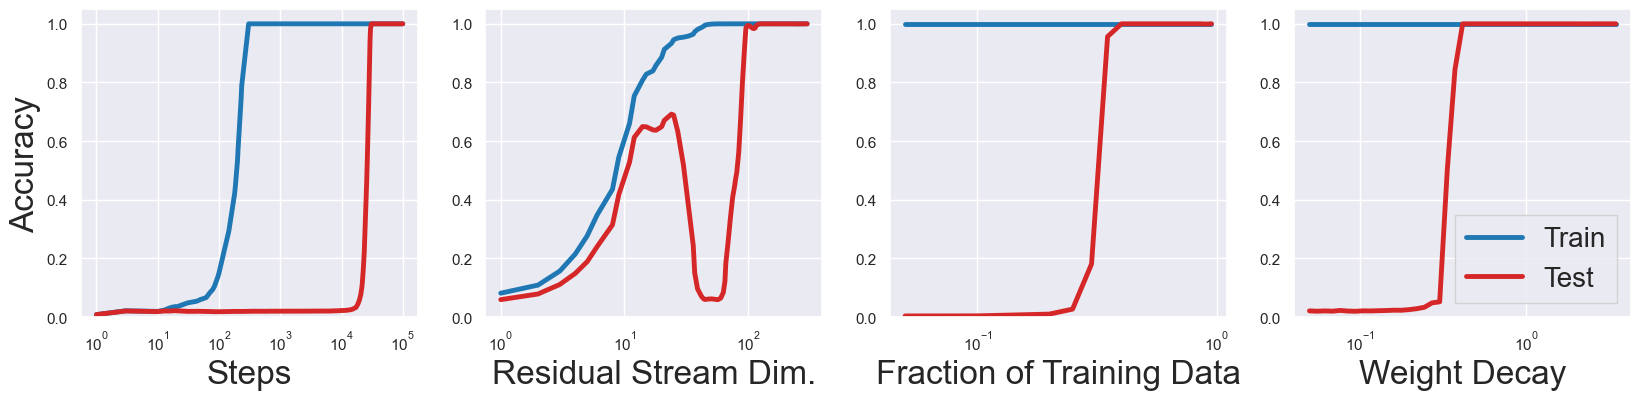

In [69]:
# Plot the 1x4 grid

fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(20, 4))

titles = ["Epoch-wise", "Model-wise", "Sample-wise", "Regularization-wise"]
xlabels = ["Steps", "Residual Stream Dim.", "Fraction of Training Data", "Weight Decay"]
ylabels = ["Accuracy", "", "", ""]
data = [(steps, ew_slice), (d_model_vals, mw_slice), (frac_train_vals, sw_slice), (wd_vals, rw_slice)]

for ax, title, xlabel, ylabel, (x, y) in zip(axes, titles, xlabels, ylabels, data):

    ax.set_ylim(0., 1.05)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)

    ax.plot(x, y["train/acc"], label="Train", color=BLUE, linewidth=3.5)
    ax.plot(x, y["test/acc"], label="Test", color=RED, linewidth=3.5)

    # Increase the font size of the x and y labels
    ax.xaxis.label.set_size(24)
    ax.yaxis.label.set_size(24)


axes[0].set_xscale('log')
axes[1].set_xscale('log')
axes[2].set_xscale('log')
axes[3].set_xscale('log')

# Add a legend at the bottom of all the plots (to be shared)
# axes[0].legend(loc='upper center', bbox_to_anchor=(2.25, -0.3), fancybox=False, shadow=False, ncol=2)
# axes[3].legend(loc='upper center', bbox_to_anchor=(0.5, -0.2), fancybox=False, shadow=False, ncol=2)
axes[3].legend(fontsize=20, loc='lower right', fancybox=False, shadow=False, ncol=1)

fig.savefig("../figures/grokking_extensions.pdf", bbox_inches='tight')

In [33]:

def plot_details(
    df: pd.DataFrame,
    unique_col: str = "weight_decay",
    smooth: Union[bool, float] = False,
    log_loss=True,
    cmap="inferno",
    log_x: bool = True,
    log_y: bool = True,
    title: str = "",
    metric: str = "test/acc",
    metric_label: str = "Accuracy",
    step: int = 10000,
    run_val: float = 0.0,
    plot_extra: bool = False,
):
    # Figure:
    # - Top Row: Heatmap stretching across
    # - Bottom Row: Two line plots.

    metric_label_short = (
        metric_label.split(" ")[1] if " " in metric_label else metric_label
    )

    # create a figure with a 2x2 grid of subplots
    fig = plt.figure(figsize=(10, 6))
    gs = gridspec.GridSpec(2, 4, width_ratios=[1.59, 6, 6, 1.59])

    pivot_table = get_pivot(
        df, unique_col, reindex=True, interpolate=True, columns=[metric]
    )
    unique_vals = sorted(df[unique_col].unique())

    ax1 = plt.subplot(gs[0, 1:])
    mesh = create_heatmap(
        x=unique_vals,
        y=pivot_table[metric].index,
        z=pivot_table[metric].values,
        ax=ax1,
        smooth=smooth,
        cmap=cmap,
        log_x=log_x,
        log_y=log_y,
        log_z=log_loss and "loss" in metric,
        title=title,
    )

    fig.colorbar(mesh, ax=ax1)
    
    # Plot a vertical line at unique_col = run_val
    ax1.axvline(x=run_val, color=BLUE, linestyle="--", linewidth=1)

    # Plot a horizontal line at step = step
    ax1.axhline(y=step, color=RED, linestyle="--", linewidth=1)

    # Line plots

    # Slice
    slice_ = extract_slice_from_pivot(pivot_table, step, metric, unique_col, smooth=smooth)

    ax2 = plt.subplot(gs[1, 1])

    if plot_extra:
        num_steps = len(df._step.unique())
        # Plot one slice every 100 steps
        slices_table = pivot_table.loc[pivot_table.index % 10 == 0, :].T.reset_index()
        slices = pd.melt(
            slices_table,
            id_vars=[unique_col, "level_0"],
            var_name="_step",
            value_name=metric,
        )

        sns.lineplot(
            data=slices,
            x=unique_col,
            y=metric,
            hue="_step",
            ax=ax2,
            alpha=100.0 / num_steps,
            palette=REDS,
            legend=False,
        )
        slice_norm = colors.Normalize(vmin=0, vmax=df._step.max())
        slice_colorbar = cm.ScalarMappable(norm=slice_norm, cmap=REDS)
        fig.colorbar(slice_colorbar, ax=ax2, label="Steps")
    
    ax2.plot(unique_vals, slice_[metric], label=title, color=RED)
    ax2.set_xlabel(title)

    # Run example
    ax3 = plt.subplot(gs[1, 2])
    kwargs = {unique_col: run_val}
    steps, run = extract_run(df, **kwargs)

    if plot_extra:
        num_vals = len(unique_vals)
        sns.lineplot(
            data=df,
            x="_step",
            y=metric,
            hue=unique_col,
            ax=ax3,
            alpha=10.0 / num_vals,
            palette=BLUES,
            legend=False,
        )
        run_norm = colors.Normalize(vmin=min(unique_vals), vmax=max(unique_vals))
        run_colorbar = cm.ScalarMappable(norm=run_norm, cmap=BLUES)
        fig.colorbar(run_colorbar, ax=ax3, label=title)

    ax3.plot(steps, run[metric], label=title, color=BLUE)
    ax3.set_xlabel("Steps")

    for ax in [ax2, ax3]:
        if "Accuracy" in metric_label:
            ax.set_ylim(0.0, 1.05)
        else:
            min_loss, max_loss = df[metric].min(), df[metric].max()
            ax.set_ylim(min_loss - 0.5 * min_loss, max_loss + 0.5 * max_loss)
            ax.set_yscale("log")

        ax.set_ylabel(metric_label_short)
        ax.set_xscale("log")

    # Adjust the layout of the subplots
    fig.suptitle(title)
    fig.tight_layout()

    return fig


def plot_all_details(
    df,
    title,
    unique_col,
    run_val,
    log_x=True,
    log_y=True,
    plot_extra=False,
    cmap="viridis",
    metrics_and_labels=[
        ("train/acc", "Train Accuracy"),
        ("test/acc", "Test Accuracy"),
        ("train/loss", "Train Loss"),
        ("test/loss", "Test Loss"),
    ],
    format="png",
    **kwargs
):
    for metric, label in metrics_and_labels:
        fig = plot_details(
            df,
            metric_label=label,
            metric=metric,
            title=title,
            unique_col=unique_col,
            run_val=run_val,
            cmap=cmap,
            log_x=log_x,
            log_y=log_y,
            plot_extra=plot_extra,
            **kwargs
        )
        slug = metric.replace("/", "_")
        fig.savefig(f"../figures/{unique_col}_{slug}.{format}", dpi=300)
        plt.show()


     d_model    level_0  _step  train/acc
0          1  train/acc  20000   0.081777
1          2  train/acc  20000   0.109297
2          3  train/acc  20000   0.157059
3          4  train/acc  20000   0.215021
4          5  train/acc  20000   0.277370
..       ...        ...    ...        ...
115      288  train/acc  20000   1.000000
116      291  train/acc  20000   1.000000
117      294  train/acc  20000   1.000000
118      297  train/acc  20000   1.000000
119      300  train/acc  20000   1.000000

[120 rows x 4 columns]


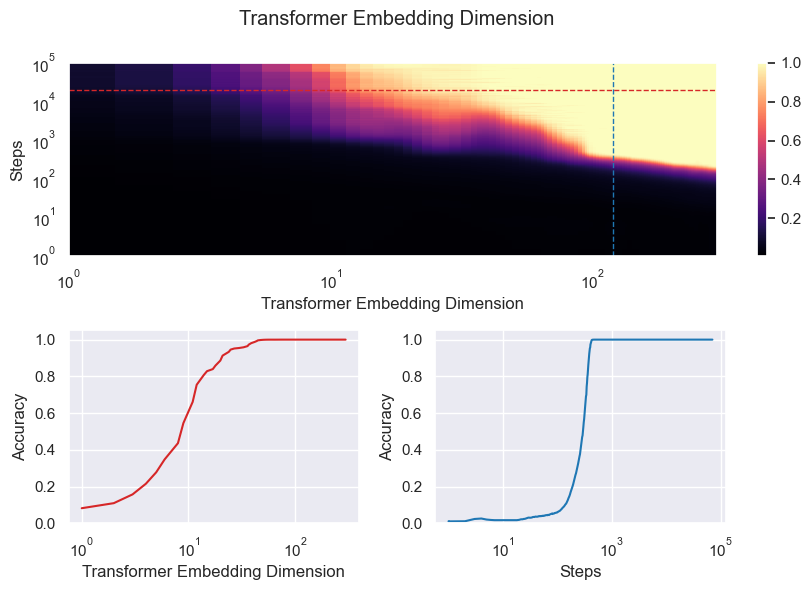

     d_model   level_0  _step  test/acc
0          1  test/acc  20000  0.059713
1          2  test/acc  20000  0.078991
2          3  test/acc  20000  0.111418
3          4  test/acc  20000  0.149061
4          5  test/acc  20000  0.189259
..       ...       ...    ...       ...
115      288  test/acc  20000  0.999952
116      291  test/acc  20000  0.999962
117      294  test/acc  20000  0.999963
118      297  test/acc  20000  0.999956
119      300  test/acc  20000  0.999949

[120 rows x 4 columns]


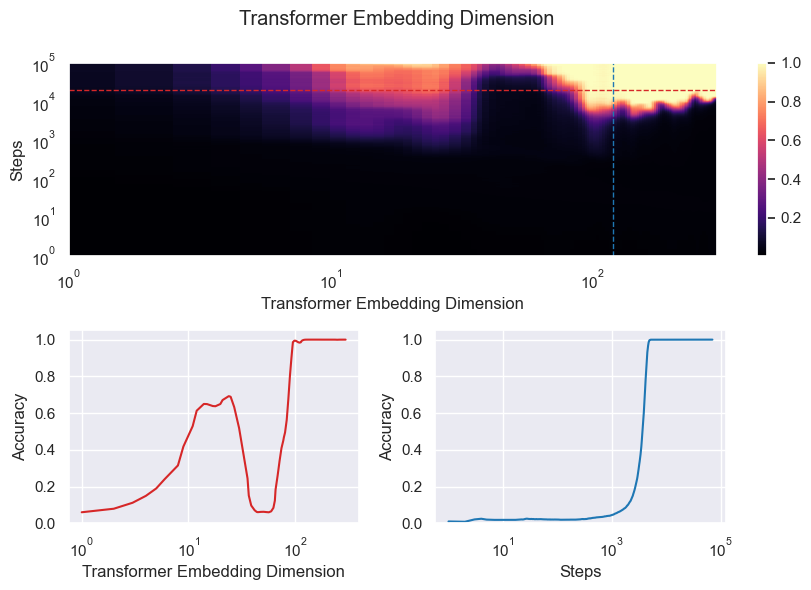

     d_model     level_0  _step    train/loss
0          1  train/loss  20000  3.755846e+00
1          2  train/loss  20000  3.513288e+00
2          3  train/loss  20000  3.112390e+00
3          4  train/loss  20000  2.669539e+00
4          5  train/loss  20000  2.270457e+00
..       ...         ...    ...           ...
115      288  train/loss  20000  2.597492e-08
116      291  train/loss  20000  2.593215e-08
117      294  train/loss  20000  2.579488e-08
118      297  train/loss  20000  2.560783e-08
119      300  train/loss  20000  2.546997e-08

[120 rows x 4 columns]


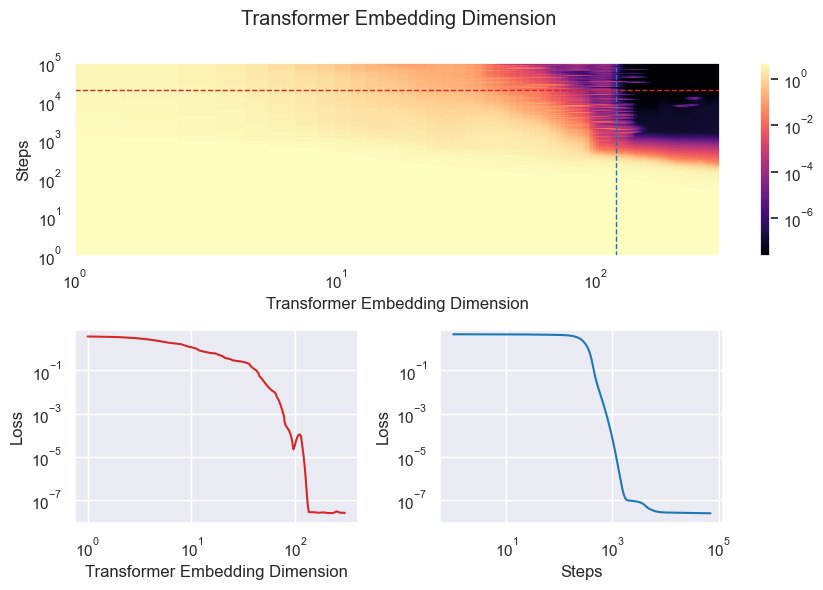

     d_model    level_0  _step  test/loss
0          1  test/loss  20000   3.883467
1          2  test/loss  20000   3.658558
2          3  test/loss  20000   3.296993
3          4  test/loss  20000   2.918819
4          5  test/loss  20000   2.606389
..       ...        ...    ...        ...
115      288  test/loss  20000   0.000524
116      291  test/loss  20000   0.000337
117      294  test/loss  20000   0.000213
118      297  test/loss  20000   0.000166
119      300  test/loss  20000   0.000160

[120 rows x 4 columns]


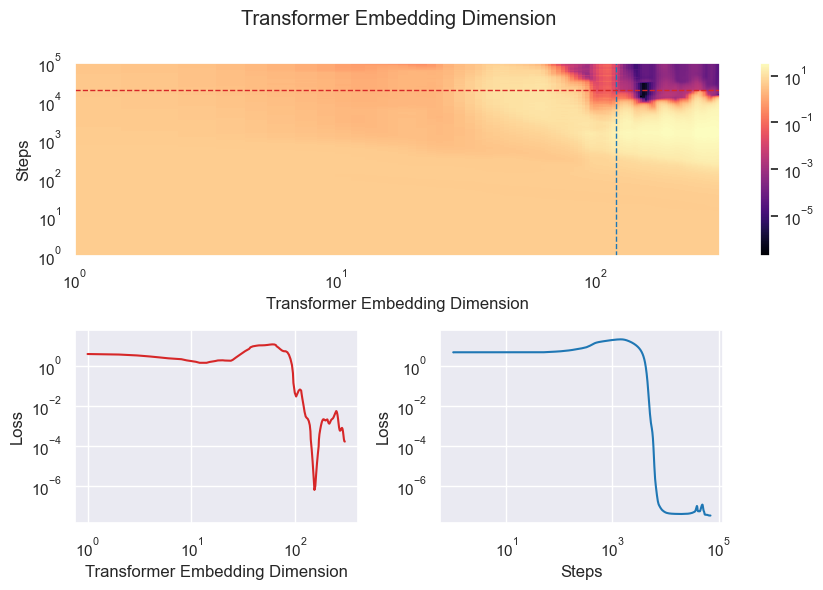

In [72]:
# Model-wise Details

# Omit all runs with d_model < 30
mw = mw_grokking_cleaned # [mw_grokking_cleaned.d_model >= 20]
plot_all_details(mw, title="Transformer Embedding Dimension", unique_col="d_model", run_val=120, plot_extra=False, smooth=2., step=20_000, cmap="magma")

    frac_train    level_0  _step  train/acc
0         0.05  train/acc  10000        1.0
1         0.10  train/acc  10000        1.0
2         0.15  train/acc  10000        1.0
3         0.20  train/acc  10000        1.0
4         0.25  train/acc  10000        1.0
5         0.30  train/acc  10000        1.0
6         0.35  train/acc  10000        1.0
7         0.40  train/acc  10000        1.0
8         0.45  train/acc  10000        1.0
9         0.50  train/acc  10000        1.0
10        0.55  train/acc  10000        1.0
11        0.60  train/acc  10000        1.0
12        0.65  train/acc  10000        1.0
13        0.70  train/acc  10000        1.0
14        0.75  train/acc  10000        1.0
15        0.80  train/acc  10000        1.0
16        0.85  train/acc  10000        1.0


/Users/Jesse/Projects/pattern-learning/unifying/sweep.py:197: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.sort_values(by="_step", inplace=True)


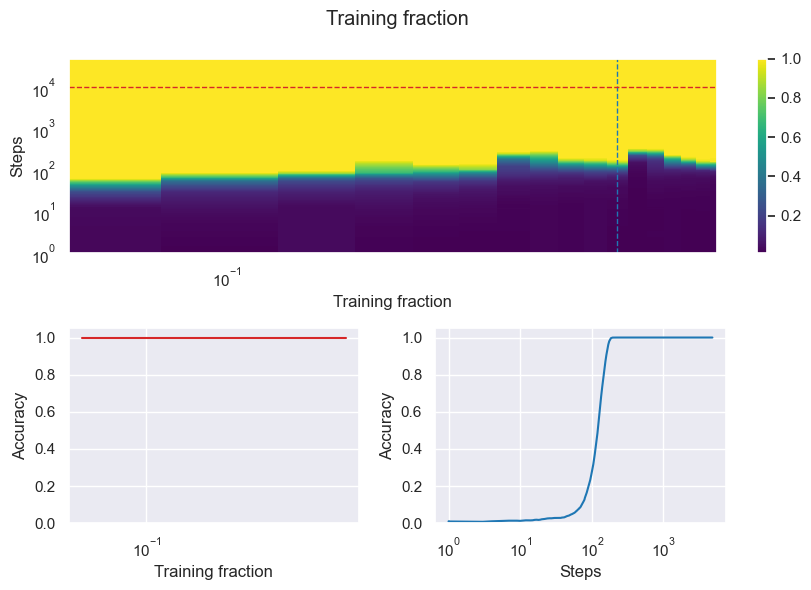

    frac_train   level_0  _step  test/acc
0         0.05  test/acc  10000  0.004067
1         0.10  test/acc  10000  0.004350
2         0.15  test/acc  10000  0.007837
3         0.20  test/acc  10000  0.010376
4         0.25  test/acc  10000  0.027357
5         0.30  test/acc  10000  0.181202
6         0.35  test/acc  10000  0.956386
7         0.40  test/acc  10000  1.000000
8         0.45  test/acc  10000  1.000000
9         0.50  test/acc  10000  1.000000
10        0.55  test/acc  10000  1.000000
11        0.60  test/acc  10000  1.000000
12        0.65  test/acc  10000  1.000000
13        0.70  test/acc  10000  1.000000
14        0.75  test/acc  10000  1.000000
15        0.80  test/acc  10000  1.000000
16        0.85  test/acc  10000  1.000000


/Users/Jesse/Projects/pattern-learning/unifying/sweep.py:197: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.sort_values(by="_step", inplace=True)


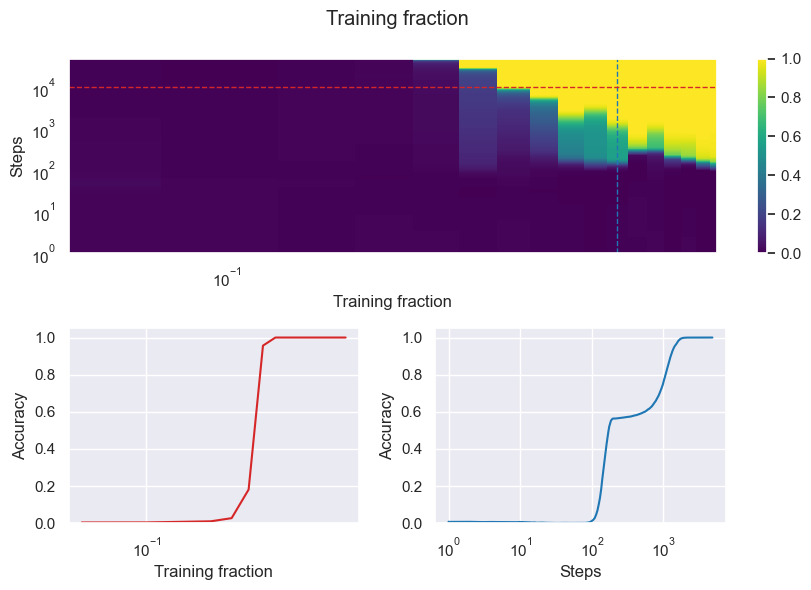

    frac_train     level_0  _step    train/loss
0         0.05  train/loss  10000  2.415377e-08
1         0.10  train/loss  10000  4.484710e-08
2         0.15  train/loss  10000  5.873640e-08
3         0.20  train/loss  10000  6.828704e-08
4         0.25  train/loss  10000  7.578422e-08
5         0.30  train/loss  10000  7.539297e-08
6         0.35  train/loss  10000  6.388754e-08
7         0.40  train/loss  10000  2.909756e-08
8         0.45  train/loss  10000  2.715228e-08
9         0.50  train/loss  10000  2.873060e-08
10        0.55  train/loss  10000  2.597562e-08
11        0.60  train/loss  10000  3.755797e-08
12        0.65  train/loss  10000  3.081671e-08
13        0.70  train/loss  10000  2.511179e-08
14        0.75  train/loss  10000  2.453608e-08
15        0.80  train/loss  10000  2.566177e-08
16        0.85  train/loss  10000  2.448805e-08


/Users/Jesse/Projects/pattern-learning/unifying/sweep.py:197: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.sort_values(by="_step", inplace=True)


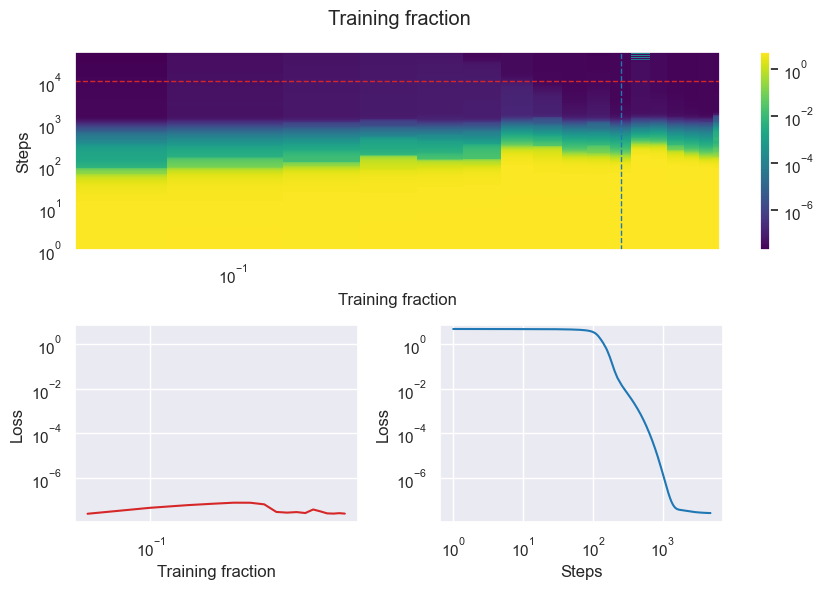

    frac_train    level_0  _step     test/loss
0         0.05  test/loss  10000  5.685209e+01
1         0.10  test/loss  10000  5.252379e+01
2         0.15  test/loss  10000  4.076200e+01
3         0.20  test/loss  10000  3.633747e+01
4         0.25  test/loss  10000  3.002062e+01
5         0.30  test/loss  10000  1.993409e+01
6         0.35  test/loss  10000  1.525530e-01
7         0.40  test/loss  10000  2.001265e-07
8         0.45  test/loss  10000  5.077036e-08
9         0.50  test/loss  10000  6.560800e-08
10        0.55  test/loss  10000  4.231463e-08
11        0.60  test/loss  10000  4.904987e-08
12        0.65  test/loss  10000  6.261543e-08
13        0.70  test/loss  10000  3.233081e-08
14        0.75  test/loss  10000  3.534535e-08
15        0.80  test/loss  10000  3.025884e-08
16        0.85  test/loss  10000  2.887921e-08


/Users/Jesse/Projects/pattern-learning/unifying/sweep.py:197: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.sort_values(by="_step", inplace=True)


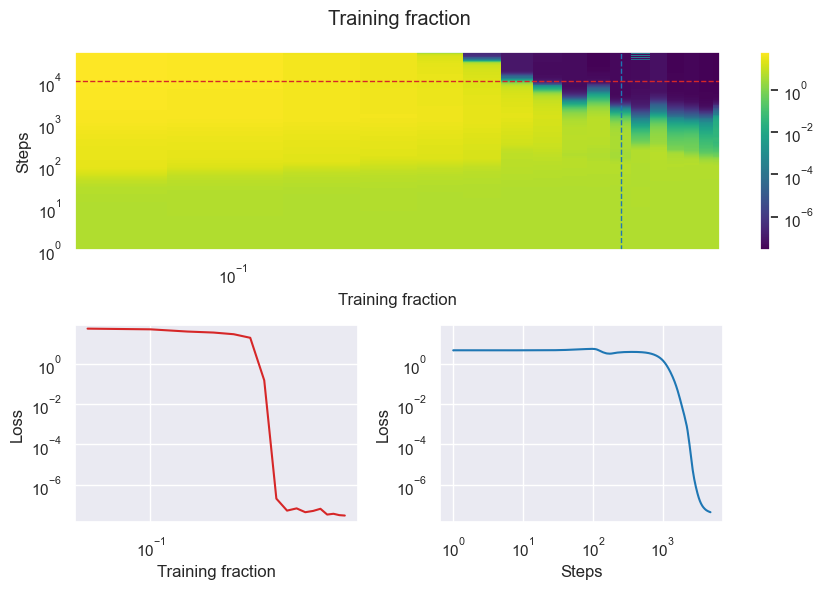

In [70]:
# Sample-wise Details

# plot_curves_2x2(sw_grokking_cleaned, title="Fraction of Training Data", unique_col="frac_train")

# plot_slice(sw_grokking_cleaned, 10000, log_loss=False, titles = {
#     "train/loss": "Train Loss",
#     "test/loss": "Validation Loss",
#     "train/acc": "Train Accuracy",
#     "test/acc": "Validation Accuracy"
# }, title="Fraction of Training Data", unique_col="frac_train", log_x=False)

# plot(sw_grokking_cleaned, smooth=0.25, log_loss=True, titles = {
#     "train/loss": "Train Loss",
#     "test/loss": "Validation Loss",
#     "train/acc": "Train Accuracy",
#     "test/acc": "Validation Accuracy"
# }, unique_col="frac_train", title="Training Fraction", log_x=False, log_y=False)

frac_trains = sw_grokking_cleaned.frac_train.unique()
frac_train_selection = frac_trains[10] 

frac_train_bads = frac_trains[-2:]
# Delete the bad run
sw_grokking_cleaned_2 = sw_grokking_cleaned[~sw_grokking_cleaned.frac_train.isin(frac_train_bads)]

plot_all_details(sw_grokking_cleaned_2, title="Training fraction", unique_col="frac_train", run_val=frac_train_selection, plot_extra=False)

    weight_decay    level_0  _step  train/acc
0       0.050000  train/acc  10000        1.0
1       0.055589  train/acc  10000        1.0
2       0.061803  train/acc  10000        1.0
3       0.068712  train/acc  10000        1.0
4       0.076393  train/acc  10000        1.0
5       0.084932  train/acc  10000        1.0
6       0.094426  train/acc  10000        1.0
7       0.104982  train/acc  10000        1.0
8       0.116717  train/acc  10000        1.0
9       0.129764  train/acc  10000        1.0
10      0.144270  train/acc  10000        1.0
11      0.160397  train/acc  10000        1.0
12      0.178327  train/acc  10000        1.0
13      0.198261  train/acc  10000        1.0
14      0.220424  train/acc  10000        1.0
15      0.245064  train/acc  10000        1.0
16      0.272458  train/acc  10000        1.0
17      0.302915  train/acc  10000        1.0
18      0.336776  train/acc  10000        1.0
19      0.374422  train/acc  10000        1.0
20      0.416277  train/acc  10000

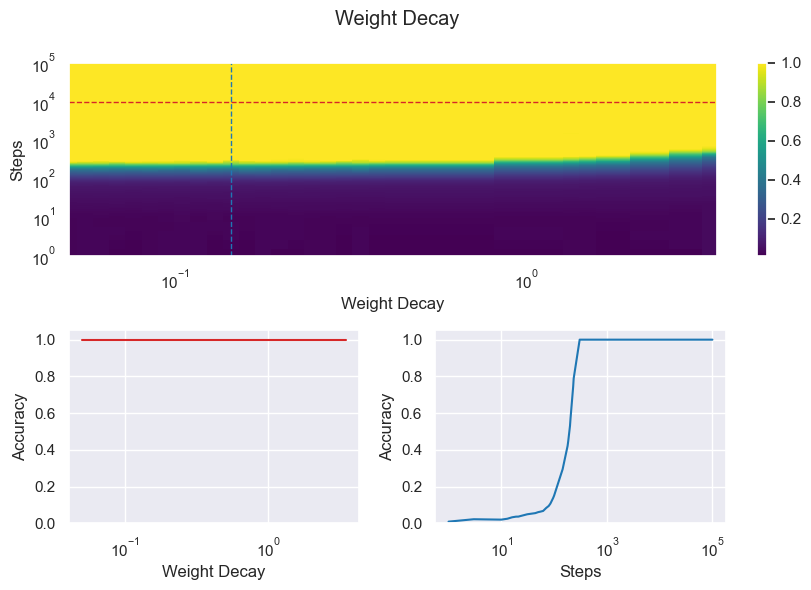

    weight_decay   level_0  _step  test/acc
0       0.050000  test/acc  10000  0.021392
1       0.055589  test/acc  10000  0.020230
2       0.061803  test/acc  10000  0.021274
3       0.068712  test/acc  10000  0.020360
4       0.076393  test/acc  10000  0.022840
5       0.084932  test/acc  10000  0.020801
6       0.094426  test/acc  10000  0.019971
7       0.104982  test/acc  10000  0.021535
8       0.116717  test/acc  10000  0.021155
9       0.129764  test/acc  10000  0.022023
10      0.144270  test/acc  10000  0.022579
11      0.160397  test/acc  10000  0.023623
12      0.178327  test/acc  10000  0.023514
13      0.198261  test/acc  10000  0.025607
14      0.220424  test/acc  10000  0.028844
15      0.245064  test/acc  10000  0.033592
16      0.272458  test/acc  10000  0.048682
17      0.302915  test/acc  10000  0.052256
18      0.336776  test/acc  10000  0.504437
19      0.374422  test/acc  10000  0.844427
20      0.416277  test/acc  10000  1.000000
21      1.201124  test/acc  1000

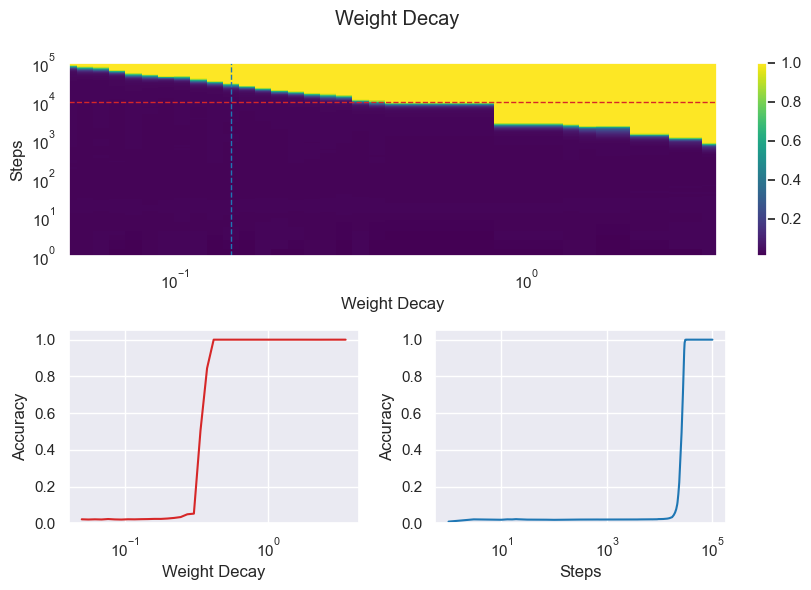

    weight_decay     level_0  _step    train/loss
0       0.050000  train/loss  10000  2.020391e-08
1       0.055589  train/loss  10000  2.260361e-08
2       0.061803  train/loss  10000  2.515117e-08
3       0.068712  train/loss  10000  2.820017e-08
4       0.076393  train/loss  10000  3.098667e-08
5       0.084932  train/loss  10000  3.476909e-08
6       0.094426  train/loss  10000  3.872829e-08
7       0.104982  train/loss  10000  4.304301e-08
8       0.116717  train/loss  10000  4.761302e-08
9       0.129764  train/loss  10000  5.298458e-08
10      0.144270  train/loss  10000  5.838056e-08
11      0.160397  train/loss  10000  6.481528e-08
12      0.178327  train/loss  10000  7.190261e-08
13      0.198261  train/loss  10000  7.890498e-08
14      0.220424  train/loss  10000  8.686847e-08
15      0.245064  train/loss  10000  9.349383e-08
16      0.272458  train/loss  10000  1.008958e-07
17      0.302915  train/loss  10000  1.119208e-07
18      0.336776  train/loss  10000  8.820719e-08


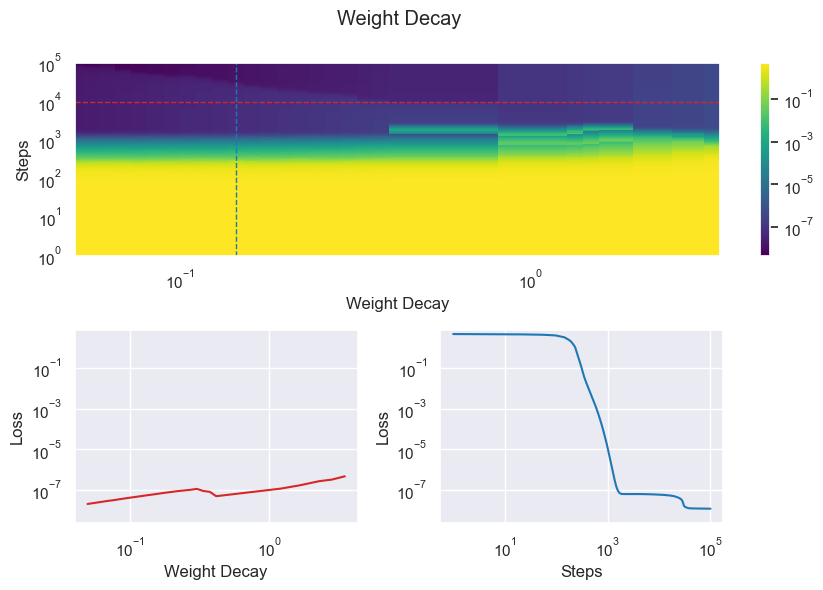

    weight_decay    level_0  _step     test/loss
0       0.050000  test/loss  10000  4.058921e+01
1       0.055589  test/loss  10000  4.011020e+01
2       0.061803  test/loss  10000  3.909396e+01
3       0.068712  test/loss  10000  3.863442e+01
4       0.076393  test/loss  10000  3.679049e+01
5       0.084932  test/loss  10000  3.648663e+01
6       0.094426  test/loss  10000  3.589397e+01
7       0.104982  test/loss  10000  3.505441e+01
8       0.116717  test/loss  10000  3.387540e+01
9       0.129764  test/loss  10000  3.290522e+01
10      0.144270  test/loss  10000  3.133028e+01
11      0.160397  test/loss  10000  3.032781e+01
12      0.178327  test/loss  10000  2.862041e+01
13      0.198261  test/loss  10000  2.680794e+01
14      0.220424  test/loss  10000  2.517155e+01
15      0.245064  test/loss  10000  2.272559e+01
16      0.272458  test/loss  10000  1.902574e+01
17      0.302915  test/loss  10000  1.835673e+01
18      0.336776  test/loss  10000  3.303545e+00
19      0.374422  te

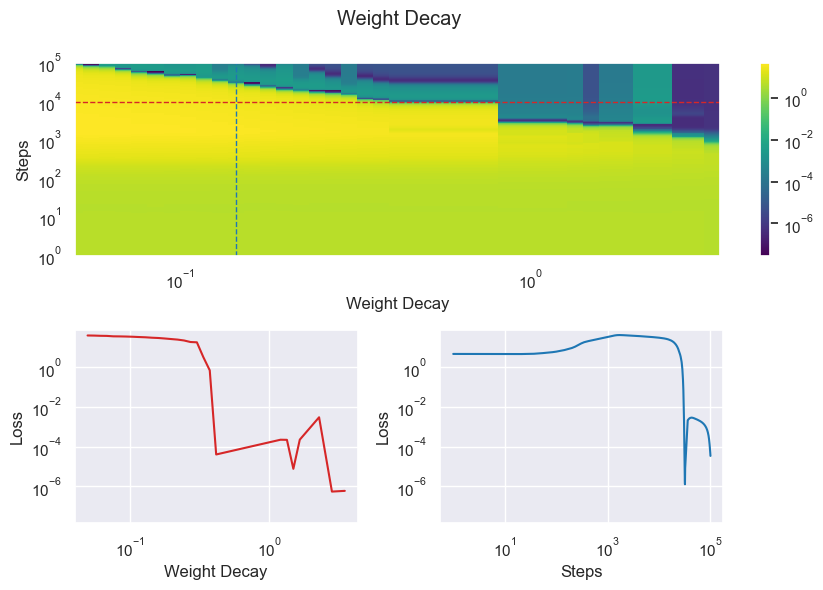

In [71]:
# Regularization-wises Details

# plot_curves_2x2(rw_grokking_cleaned, title="Weight Decay", unique_col="weight_decay")
# plot_slice(rw_grokking_cleaned, 10010, smooth=True, log_loss=False, titles = {
#     "train/loss": "Train Loss",
#     "test/loss": "Validation Loss",
#     "train/acc": "Train Accuracy",
#     "test/acc": "Validation Accuracy"
# }, title="Weight Decay")

# plot(rw_grokking_cleaned,   smooth=True, log_loss=False, titles = {
#     "train/loss": "Train Loss",
#     "test/loss": "Validation Loss",
#     "train/acc": "Train Accuracy",
#     "test/acc": "Validation Accuracy"
# }, title="Weight Decay")


plot_all_details(rw_grokking_cleaned, title="Weight Decay", unique_col="weight_decay", run_val=wd_selection, plot_extra=False)

# Interpolations

In [11]:

def plot_interpolation_overview(
    df: pd.DataFrame,
    unique_col: str = "weight_decay",
    smooth: Union[bool, float] = False,
    cmap="inferno",
    log_loss=True,
    log_x: bool = True,
    log_y: bool = True,
    title: str = "",
    metric: str = "test/acc",
    metric_label: str = "Accuracy",
    run_vals: List[float] = [0.0],
    plot_extra: bool = False,
    latex: str = "",
    suptitle: str = "",
):
    metric_label_short = (
        metric_label.split(" ")[1] if " " in metric_label else metric_label
    )

    num_snapshots = len(run_vals)

    # create a figure with a 2x2 grid of subplots
    fig = plt.figure(figsize=(10, 6))
    gs = gridspec.GridSpec(num_snapshots, 2, width_ratios=[3, 2], hspace=0.25)

    pivot_table = get_pivot(
        df, unique_col, reindex=True, interpolate=True, columns=[metric]
    )
    unique_vals = sorted(df[unique_col].unique())

    ax1 = plt.subplot(gs[:, 0])
    y = pivot_table[metric].index
    mesh = create_heatmap(
        x=unique_vals,
        y=y,
        z=pivot_table[metric].values,
        ax=ax1,
        smooth=smooth,
        cmap=cmap,
        log_x=log_x,
        log_y=log_y,
        log_z=log_loss and "loss" in metric,
        title=title,
    )

    fig.colorbar(mesh, ax=ax1, label="Test Accuracy")

    # Plot horizontal lines at the run_vals entries
    run_vals_lines = [(v + 0.0125 if v == 0 else v) for v in run_vals]
    ax1.vlines(run_vals_lines, y.min(), y.max(), color=RED)

    # Find the _step for each run where the train/acc first reaches 1.0
    interpolation = []
    convergence = []

    for i, val in enumerate(unique_vals):
        run = df.loc[(df[unique_col] == val), :]

        interp_max = run["train/acc"].max()
        interp_threshold = interp_max * 0.95
        interp_step = run.loc[run["train/acc"] > interp_threshold, "_step"].min()  # type: ignore
        interp_val = run.loc[run._step == interp_step, "train/acc"].values[0]  # type: ignore
        interpolation.append((interp_step, interp_val))

        conv_max = run[metric].max()
        conv_threshold = conv_max * 0.95
        conv_step = run.loc[run[metric] > conv_threshold, "_step"].min()  # type: ignore
        conv_val = run.loc[run._step == conv_step, metric].values[0]  # type: ignore
        convergence.append((conv_step, conv_val))

    ax1.plot(
        unique_vals,
        [v for (v, _) in interpolation],
        color="grey",
        linestyle="--",
        label="Interpolation",
    )
    ax1.plot(
        unique_vals,
        [v for (v, _) in convergence],
        color="grey",
        linestyle="--",
        label="Convergence",
    )

    for i, val in enumerate(run_vals):
        run = df.loc[(df[unique_col] == val), :]
        ax = plt.subplot(gs[i, 1])

        # Interpolation threshold
        unique_val_idx = unique_vals.index(val)

        interp_step, interp_val = interpolation[unique_val_idx]
        ax.vlines(interp_step, 0, interp_val, color="grey", linestyle="--", label=None)

        # Test convergence threshold
        conv_step, conv_val = convergence[unique_val_idx]
        ax.vlines(conv_step, 0, conv_val, color="grey", linestyle="--", label=None)

        ax.plot(run._step, run["train/acc"], color=BLUE, label="Train")
        ax.plot(run._step, run[metric], color=RED, label="Test")

        val_rounded = round(val, 2)
        ax.set_title(f"{metric_label_short} for ${latex}={val_rounded}$")

        ax.set_ylim([0.0, 1.05])
        ax.set_xscale("log")
        ax.set_xlim([1e0, df._step.max()])

        if i < len(run_vals) - 1:
            ax.set_xticklabels([])
        else:
            ax.set_xlabel("Step")

        if i == 0:
            ax.legend(loc="lower right")

    plt.suptitle(suptitle)


In [2]:
ln_sweep = get_history("xwna3rhg", allow_duplicates=True)

# ln_sweep_cleaned = handle_outliers(
#     ln_sweep,
#     loss_cols=["train/loss"], 
#     action="keep",
#     unique_cols=["frac_train"],
#     threshold=0.0001,
#     late_epochs_ratio=0.6,
# )


def correct_label_noise(df: pd.DataFrame):
    # Correct the sweeps by dividing test/acc by 1-label_noise
    df = df.copy()

    lbl_noises = df.frac_label_noise.unique()

    for lbl_noise in lbl_noises:
        for metric in ["test/acc"]:
            df.loc[df.frac_label_noise==lbl_noise, metric] /= 1 - lbl_noise

    return df

ln_sweep_cleaned = correct_label_noise(ln_sweep)

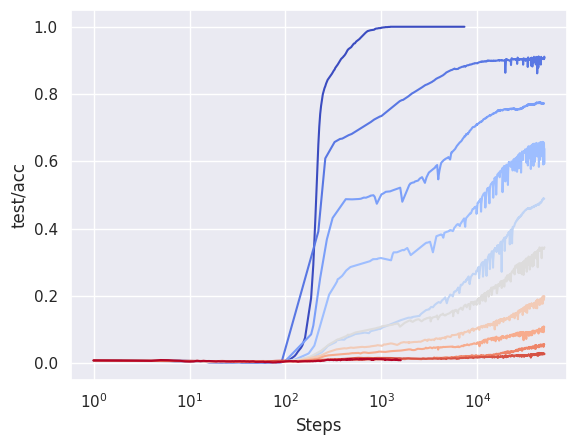

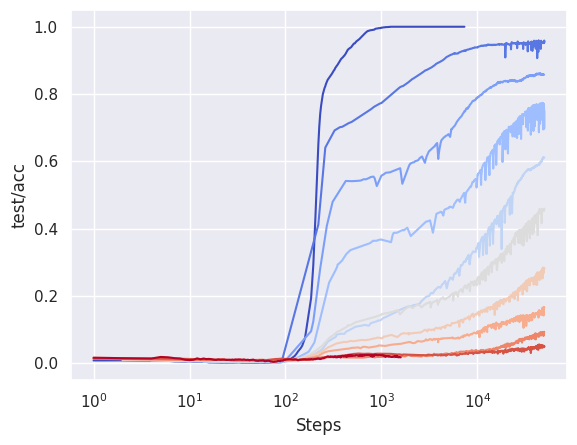

In [7]:
sns.lineplot(ln_sweep, x="_step", y="test/acc", hue="frac_label_noise", legend=False, palette="coolwarm", )
plt.xscale('log')
plt.xlabel("Steps")
plt.show()

sns.lineplot(ln_sweep_cleaned, x="_step", y="test/acc", hue="frac_label_noise", legend=False, palette="coolwarm", )
plt.xscale('log')
plt.xlabel("Steps")
plt.show()

In [4]:
plot_interpolation_overview(
    ln_sweep_cleaned,
    unique_col="frac_label_noise",  
    title="Fraction training noise",
    cmap="coolwarm",
    run_vals=[0.0, 0.05, 0.15],
    latex=r"f_\mathrm{noise}",
    log_x=False,
    suptitle="Modular Arithmetic"
)   

NameError: name 'gridspec' is not defined

<Figure size 1000x600 with 0 Axes>

In [2]:
frac_train_sweep = get_history("cnr2n43n", "759uhy5f", allow_duplicates=True, project="mnist-grokking")

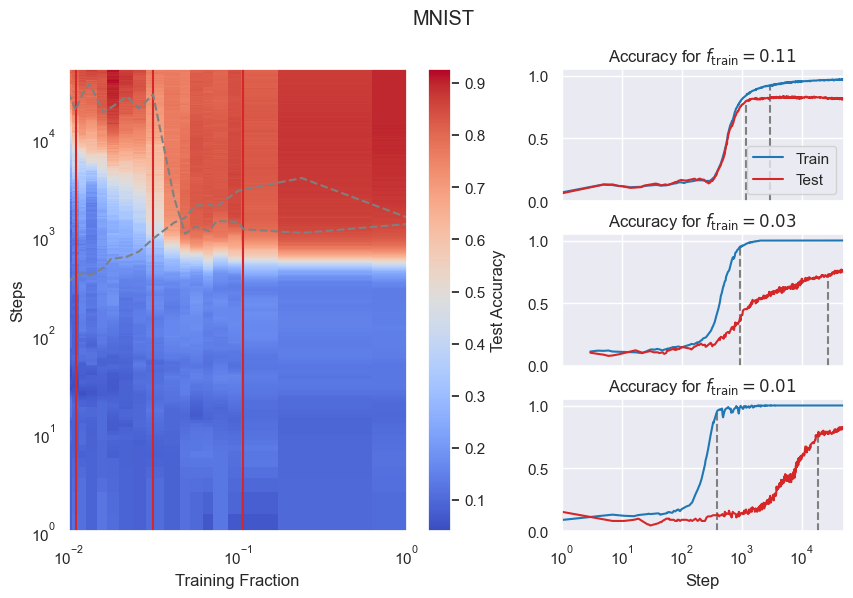

In [15]:
ft_vals = sorted(frac_train_sweep.frac_train.unique())
ft_selection = [ft_vals[-3], ft_vals[8], ft_vals[1]]

plot_interpolation_overview(
    frac_train_sweep,
    unique_col="frac_train",
    title="Training Fraction",
    cmap="coolwarm",
    run_vals=ft_selection,
    latex=r"f_\mathrm{train}",
    log_x=True,
    suptitle="MNIST"
) 

In [5]:
api = wandb.Api()
mnist_dd = api.run("jqhoogland/mnist-grokking/hbw3nlnb")
mnist_grok = api.run("jqhoogland/mnist-grokking/9i790lal")

mnist_dd_df = pd.DataFrame(mnist_dd.history())
mnist_grok_df = pd.DataFrame(mnist_grok.history())

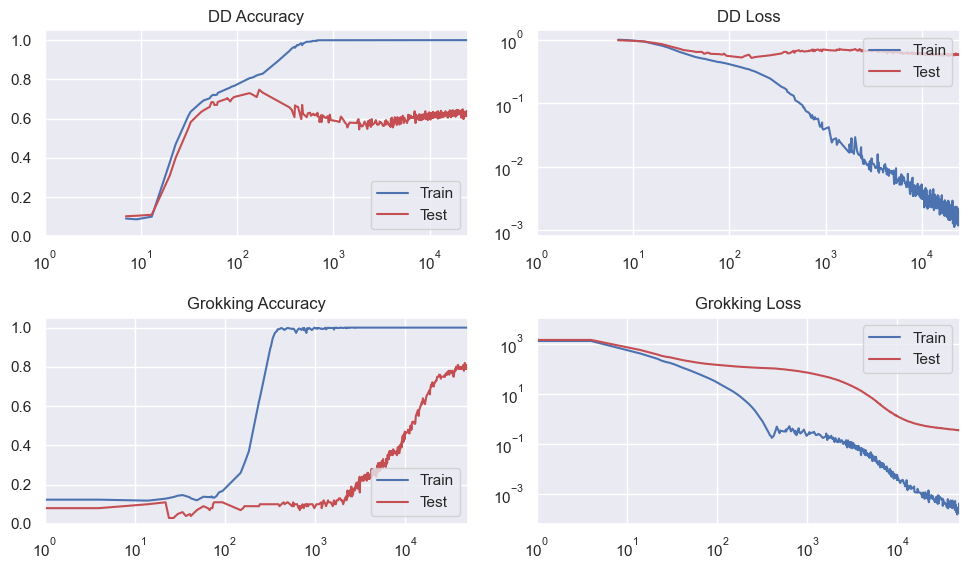

In [14]:
# 2 by 2 grid of subplots
# Acc on left, loss on right
# DD on top, Grokking on bottom
# Train in blue, test in red

fig, axes = plt.subplots(2, 2, figsize=(10, 6))

for i, (df, title) in enumerate(zip([mnist_dd_df, mnist_grok_df], ["DD", "Grokking"])):
    ax = axes[i, 0]
    # Sort by steps
    df = df.sort_values("_step")

    ax.plot(df._step, df["train/acc"], color=BLUE, label="Train")
    ax.plot(df._step, df["test/acc"], color=RED, label="Test")
    ax.set_title(f"{title} Accuracy")
    ax.set_ylim([0., 1.05])
    ax.set_xscale("log")
    ax.set_xlim([1e0, df._step.max()])
    ax.legend(loc="lower right")

    ax = axes[i, 1]
    ax.plot(df._step, df["train/loss"], color=BLUE, label="Train")
    ax.plot(df._step, df["test/loss"], color=RED, label="Test")
    ax.set_title(f"{title} Loss")
    ax.set_xscale("log")
    ax.set_yscale("log")
    ax.set_xlim([1e0, df._step.max()])
    ax.legend(loc="upper right")

# More space between rows
fig.tight_layout(pad=1.5)


### Can we recreate grokking on MNIST?

In [ ]:
mnist_config = MNISTConfig(
    wandb_project="mnist-grokking",
    frac_train=1/60.,
    frac_label_noise=0.0,
    batch_size=200,
    num_training_steps=int(1e6),
    num_layers=2,
    width=200,
    init_mode="uniform",
    init_scale=6.,
    lr=1e-3, # 1e-3
    weight_decay=1e-2, # 1e-2
    seed=0,
    device=DEVICE,
    use_sgd=False
    # criterion="mse"
)

mnist_learner = MNISTLearner.create(
    mnist_config,
    mnist_train,
    mnist_test,
)

Model has 199210 trainable parameters


In [ ]:
try:
    wandb.init(
        project="mnist-grokking",
        settings=wandb.Settings(start_method="thread"),
        config=asdict(mnist_config),  # Default config
    )
    mnist_learner.train()
except KeyboardInterrupt:
    wandb.finish()

  0%|          | 0/200000 [00:00<?, ?it/s]

In [ ]:
mnist_dd_config = MNISTConfig(
    wandb_project="mnist-dd",
    frac_train=1.,
    frac_label_noise=0.2,
    batch_size=256,
    num_training_steps=int(60e3/256 * 1000),
    num_layers=2,
    width=200,
    init_mode="uniform",
    init_scale=1.,
    lr=1e-3, # 1e-3
    weight_decay=1e-2, # 1e-2
    seed=0,
    device=DEVICE,
    use_sgd=False
    # criterion="mse"
)

mnist_dd_learner = MNISTLearner.create(
    mnist_dd_config,
    mnist_train,
    mnist_test,
)

Model has 199210 trainable parameters


In [ ]:
try:
    wandb.init(
        project=mnist_dd_config.wandb_project,
        settings=wandb.Settings(start_method="thread"),
        config=asdict(mnist_dd_config),  # Default config
    )
    mnist_dd_learner.train()
except KeyboardInterrupt:
    wandb.finish()

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: jqhoogland. Use `wandb login --relogin` to force relogin


  0%|          | 0/997 [00:00<?, ?it/s]

test/acc,▁▄▅▇▇▇▇▇▇▇▇▇▇█▇█▇███████████████████████
test/efficiency,█▆▅▄▄▄▃▄▃▃▃▃▃▃▃▃▃▃▂▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁
test/loss,█▆▅▄▃▃▃▃▃▃▂▂▂▂▃▂▂▂▂▂▂▂▁▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train/acc,▁▄▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇██████████████████████
train/efficiency,█▆▅▄▄▃▃▃▃▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁
train/loss,█▆▄▄▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
weight/cos_sim_with_init,███▇▇▇▇▇▇▇▇▇▇▇▇▆▆▆▆▆▆▆▆▅▅▅▄▄▄▄▃▃▃▃▂▂▂▂▁▁
weight/dist_from_init,▁▂▂▂▃▃▃▃▃▃▃▃▄▄▄▄▄▄▄▄▄▄▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
weight/norm,▁▁▁▁▂▂▂▂▂▂▂▂▂▂▂▂▂▃▃▃▃▃▃▃▄▄▄▄▅▅▅▆▆▆▆▇▇▇██
test/acc,0.7946
test/efficiency,0.02905


### Can we induce grokking in CIFAR-10?

In [ ]:
# Transform to black & white & crop to 28 x 28 & normalize

cifar_train_bw = CIFAR10(root="../data", train=True, download=True, transform=transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914,), (0.2023,)),
    transforms.Grayscale(),
    transforms.CenterCrop(28),
]))
cifar_test_bw = CIFAR10(root="../data", train=False, download=True, transform=transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914,), (0.2023,)),
    transforms.Grayscale(),
    transforms.CenterCrop(28),
]))

# First try with the MNIST model

cifar_config_bw = MNISTConfig(
    wandb_project="cifar-grokking",
    frac_train=1/60.,
    frac_label_noise=0.0,
    batch_size=200,
    num_training_steps=int(1e6),
    num_layers=2,
    width=200,
    init_mode="uniform",
    init_scale=6.,
    lr=1e-3, # 1e-3
    weight_decay=1e-2, # 1e-2
    seed=0,
    device=DEVICE,
    use_sgd=False
    # criterion="mse"
)

cifar_learner_bw = MNISTLearner.create(
    cifar_config_bw,
    cifar_train_bw,
    cifar_test_bw,
)

def run(learner: BaseLearner, config: Config):
    try:
        wandb.init(
            project=config.wandb_project,
            settings=wandb.Settings(start_method="thread"),
            config=asdict(config),
        )
        learner.train()
    except KeyboardInterrupt:
        wandb.finish()

# run(cifar_config_bw, cifar_learner_bw)

Files already downloaded and verified
Files already downloaded and verified
Model has 199210 trainable parameters


In [ ]:
class ResBlock(ExtModule):
    def __init__(self, in_channels, out_channels, kernel_size=3, use_1x1conv=False, strides=1):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=kernel_size, padding=1, stride=strides)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=kernel_size, padding=1)
        
        if use_1x1conv:
            self.conv3 = nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=strides)
        else:
            self.conv3 = None

        self.bn1 = nn.BatchNorm2d(out_channels)
        self.bn2 = nn.BatchNorm2d(out_channels)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        
        if self.conv3:
            x = self.conv3(x)
        
        out += x
        return F.relu(out)

class ResNet(ExtModule):
    def __init__(
        self, 
        num_blocks: int,
        num_classes: int,
        in_channels: int = 3,
        in_width: int = 32,
        init_scale: float = 1.,
    ):
        super().__init__()

        self.in_width = in_width
        self.in_channels = in_channels
        self.num_blocks = num_blocks
        self.num_classes = num_classes
        self.init_scale = init_scale
        
        self.conv1 = nn.Conv2d(in_channels, 32, kernel_size=5, stride=2, padding=0, bias=False)
        size = (in_width - 5) // 2 + 1

        self.bn1 = nn.BatchNorm2d(32)

        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        size = (size - 3) // 2 + 1

        resblocks = [
            ResBlock(32 * (2 ** i), 32 * (2 ** (i + 1)), strides=2, kernel_size=3)
            for i in range(num_blocks)
        ]

        for i, _ in enumerate(resblocks):
            size = (size - 3) // 2 + 1

        self.resblocks = nn.Sequential(*resblocks)

        self.flatten = nn.Flatten()
        num_channels = 32 * (2 ** num_blocks)
        self.fc1 = nn.Linear(num_channels * size, num_classes)

        self.init_weights()

    def forward(self, x):
        out = self.conv1(x)
        out = self.bn1(out)

        out = self.maxpool(out)
        out = self.resblocks(out)
        out = self.flatten(out)
        out = self.fc1(out)
        return out
    

@dataclass
class CIFARConfig(VisionConfig):
    num_blocks: int = 2
    num_classes: int = 10
    in_channels: int = 3
    in_width: int = 32 


class CIFARLearner(BaseLearner):
    Config = CIFARConfig
    Dataset = Union[CIFAR10, Subset[CIFAR10]]

    @classmethod
    def create(
        cls,
        config: Config,
        trainset: Dataset,
        testset: Dataset,
    ) -> "BaseLearner":
        torch.manual_seed(config.seed)
        model = cls.get_model(config)
        optimizer = cls.get_optimizer(config, model)
        trainloader = cls.get_loader(config, trainset)
        testloader = cls.get_loader(config, testset, train=False)
        return cls(model, optimizer, config, trainloader, testloader)

    @staticmethod
    def get_loader(config: Config, dataset: Dataset, train=True) -> DataLoader[Dataset]:
        def add_label_noise(dataset: CIFARLearner.Dataset, frac_label_noise: float) -> CIFARLearner.Dataset:
            num_samples = len(dataset)
            num_errors = int(num_samples * frac_label_noise)
            
            origin_indices = torch.randperm(num_samples)[:num_errors]
            target_indices = origin_indices.roll(1)

            for origin, target in zip(origin_indices, target_indices):
                dataset.targets[origin] = dataset.targets[target]  # TODO: Make this not in-place

            return dataset

        if config.frac_label_noise > 0.0:
            dataset = add_label_noise(dataset, config.frac_label_noise)

        if train and config.frac_train < 1.0:
            dataset = Subset(
                dataset, 
                list(range(int(len(dataset) * config.frac_train)))
            )

        return DataLoader(
            dataset,
            batch_size=config.batch_size,
            shuffle=train,
        )

    @classmethod
    def get_model(cls, config: Config) -> nn.Module:
        model = ResNet(
            num_blocks=config.num_blocks,
            num_classes=config.num_classes,
            in_channels=config.in_channels,
            in_width=config.in_width,
            init_scale=config.init_scale,
        )

        if config.load_path is not None:
            model.load_state_dict(torch.load(config.load_path))

        model.to(config.device)

        num_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
        print(f"Model has {num_params} trainable parameters")

        return model

cifar_config = CIFARConfig(
    batch_size=256,
    wandb_project="cifar10-grokking",
    frac_train=0.0167,
    init_scale=8.,
    frac_label_noise=0.2,
    num_training_steps=int(60000. / 256 * 200),
)

cifar_train = CIFAR10(root="../data", train=True, download=True, transform=transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914,), (0.2023,)),
]))
cifar_test = CIFAR10(root="../data", train=False, download=True, transform=transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914,), (0.2023,)),
]))

cifar_learner = CIFARLearner.create(
    cifar_config,
    trainset=cifar_train,
    testset=cifar_test,
)    

run(cifar_learner, cifar_config)

Files already downloaded and verified
Files already downloaded and verified
Model has 280106 trainable parameters


RuntimeError: The size of tensor a (4) must match the size of tensor b (7) at non-singleton dimension 3

### Can we interpolate just by varying initialization scale and label noise?

## Miscellaneous


### Can we induce epoch-/regularization-wise DD in shallow models?

### Can we induce epoch-wise DD in transformers?

In [74]:
import torch
from torch.utils.data import DataLoader, Dataset

# Define an empty dataset
class EmptyDataset(Dataset):
    def __init__(self):
        pass

    def __len__(self):
        return 0

    def __getitem__(self, index):
        pass

# Create an empty dataset object
empty_dataset = EmptyDataset()

# Create an empty dataloader
dataloader = DataLoader(empty_dataset, batch_size=32, shuffle=True)

# Iterate over the dataloader (won't execute any iterations since the dataset is empty)
for batch in dataloader:
    print(batch)


ValueError: num_samples should be a positive integer value, but got num_samples=0